# <h3 align="center">**COVID-19: Face Mask Detector with OpenCV, Keras/TensorFlow, and Deep Learning**</h3> 




![picture](https://www.pyimagesearch.com/wp-content/uploads/2020/04/face_mask_detection_dataset.jpg)
---
This project is composed from 2 phases :

![picture](https://www.pyimagesearch.com/wp-content/uploads/2020/04/face_mask_detection_phases.png) 


In [ ]:


---


**A) In this notebook**, we will do thae first phase : training a COVID-19 face mask classifier with OpenCV, Keras/TensorFlow, and Deep Learning.

the output of the notebook is a tensorflow model that classifies a face image into "with mask" or "without mask".

let's name it MaskNet !



---


**B) In the second phase**, you will make 2 python scripts to :

1- Detect COVID-19 face masks in images

2- Detect face masks in real-time video streams using web cam or IP camera 

please see the attached files

 The main 2 components of the detection process are :

* Extracting the Face Image (or let say our region of interest ROI) from the original picture using OpenCV and faceNet !


* Classifying the ROI into  "with face mask" or "without face mask" using the Machine Learning model trained in this notebook
   
yoi will apply this for every frame and you will show the output results on the screen.



Let's start :

Remark : you can upload everything on google colab and train the model or you can train it on your PC, but first you need to install the required libraries as follows :

1. Put the files in a directory, name it mask-detection for example !
2. Change your directory to mask-detection and create a Python conda or a virtual environment named 'maskdetection_env' for example

* for Conda:

```
$ conda create -n maskdetection_env python=3.6
$ source activate maskdetection_env
```

* for venv :

```
$ mkvirtualenv maskdetection_env
```

3. Now, run the following command in your Terminal/Command Prompt to install the libraries required

```
$ pip3 install -r requirements.

##1. importing the necessary libraries :


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

## 2. Loading the Dataset :

the dataset is composed from 2 folders :
* with_mask
* without_mask

In [23]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
datapath = "/content/Mask-Detection/dataset"
imagePaths = list(paths.list_images(datapath))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [12]:
print('Data shape : ',data.shape)
print('labels shape : ',labels.shape)
from collections import Counter
Counter(labels)

Data shape :  (3846, 224, 224, 3)
labels shape :  (3846,)


Counter({'with_mask': 1916, 'without_mask': 1930})

So we have now 3846 images with shape 224 * 224 * 3 divided into :
* with_mask : 1916
* without_mask : 1930

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


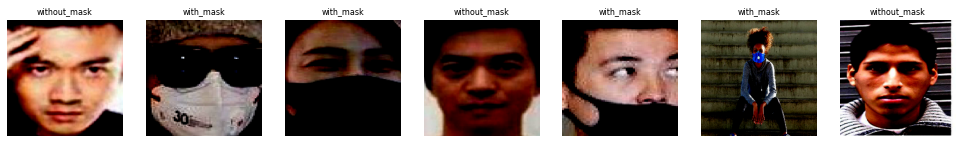

In [19]:
### let's view a sample
import random 
W_grid = 7
L_grid = 1
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel()
for i in range(W_grid):
  index = random.randint(0,len(data)) 
  axes[i].imshow(data[index])
  axes[i].set_title(labels[index], fontsize = 8)
  axes[i].axis('off')


##3. Data Preprocessing and augmentation:

In [24]:

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation using shift, flips etc.....
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


##4. Building the classification model : 

The Model is composed from 2 parts :
* The feature extraction part : here you generally use convolutional neural networks. In this case we will rely on MobileNetV2 pretrained model as it is a good feature extractor.

* The classification part: The extracted features will be fed to fully connected layers that perform the clasification

![pic2](https://www.quantmetry.com/wp-content/uploads/2019/03/image-1.png)



In [25]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headM# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32odel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling face mask ditection model...")

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...


##5. Model training :

We will optimize the binary_crossentropy loss function using adam optimizer

In [26]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# compile our model
print("[INFO] compiling face mask ditection model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] train head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
96/96 [==============================] - 40s 331ms/step - loss: 0.5463 - accuracy: 0.7644 - val_loss: 0.1743 - val_accuracy: 0.9714
Epoch 2/20
96/96 [==============================] - 31s 318ms/step - loss: 0.1710 - accuracy: 0.9597 - val_loss: 0.1089 - val_accuracy: 0.9766
Epoch 3/20
96/96 [==============================] - 31s 318ms/step - loss: 0.1015 - accuracy: 0.9769 - val_loss: 0.0824 - val_accuracy: 0.9831
Epoch 4/20
96/96 [==============================] - 31s 321ms/step - loss: 0.0772 - accuracy: 0.9788 - val_loss: 0.0742 - val_accuracy: 0.9792
Epoch 5/20
96/96 [==============================] - 31s 318ms/step - loss: 0.0658 - accuracy: 0.9796 - val_loss: 0.0692 - val_accuracy: 0.9818
Epoch 6/20
96/96 [==============================] - 31s 320ms/step - loss: 0.0655 - accuracy: 0.9845 - val_loss: 0.0690 - val_accuracy: 0.9766
Epoch 7/20
96/96 [==============================] - 31s 319ms/step - loss: 0.0553 - accuracy

In [28]:
# serialize the model to disk
print("[INFO] saving face mask detector model...")
model.save("mask_classifier.model", save_format="h5")

[INFO] saving mask detector model...


##6. Results :

In [29]:

# make predictions on the testing set
print("[INFO] evaluating networks...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       384
without_mask       0.99      0.97      0.98       386

    accuracy                           0.98       770
   macro avg       0.98      0.98      0.98       770
weighted avg       0.98      0.98      0.98       770



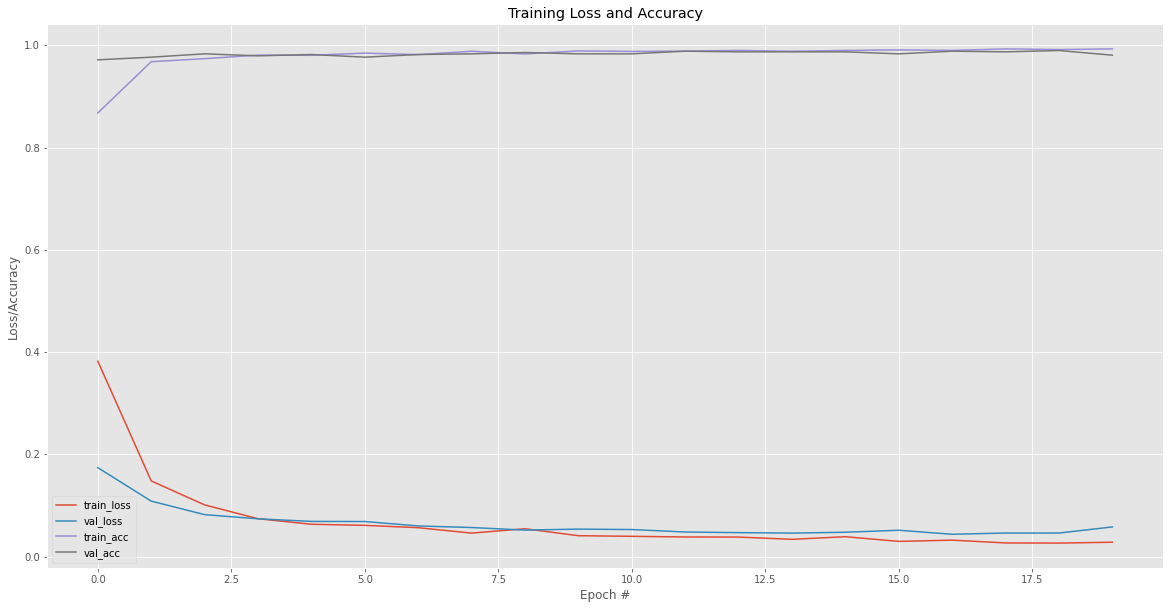

In [35]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.jpg")

##7. Usage :


## 🚀&nbsp; Installation
1. Put the files in a directory, name it mask-detection for example !
2. Change your directory to mask-detection and create a Python conda or a virtual environment named 'maskdetection_env' for example

* for Conda:

```
$ conda create -n maskdetection_env python=3.6
$ source activate maskdetection_env
```

* for venv :

```
$ mkvirtualenv maskdetection_env
```

3. Now, run the following command in your Terminal/Command Prompt to install the libraries required

```
$ pip3 install -r requirements.txt
```

##  Working


you can choose either to detect from image or from webcam:

1. To detect face masks in an image type the following command: 
```
$ python3 detect_mask_image.py --image images/pic1.jpeg
```

2. To detect face masks in real-time video streams type the following command:
```
$ python3 detect_mask_video.py 
```


Enjoy !!
